Name: Andrew Lauwira

NIM: 2440035904

For the forest fire segmentation task, I would recommend using a convolutional neural network (CNN) with a fully convolutional network (FCN) architecture. The architecture I would suggest is a modified version of the U-Net architecture.

The reason for choosing the U-Net architecture is because it is well-suited for image segmentation tasks, and has been used successfully on various tasks such as medical image segmentation. The U-Net architecture consists of a contracting path, which is used to capture the context of the image, and a symmetrical expanding path, which is used to localize the target objects. The contracting path consists of several convolutional layers, followed by max-pooling layers, to reduce the spatial dimensions. The expanding path consists of several upsampling layers, followed by convolutional layers, to increase the spatial dimensions.

In [28]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(48)

Creating a function to resize the original images and their masks

In [29]:
## resizing images 
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

Getting the image path pattern to fetch the images using python glob module


In [30]:
image_path = "Aerial Image Dataset\Forest Segmented\Forest Segmented\images\*.jpg"
mask_path = "Aerial Image Dataset\Forest Segmented\Forest Segmented\masks\*.jpg"

Sorting the original images and their mask
The sorting is highly necessary. It is not necessary that the images that we load will get loaded in given order only. So, we need to sort in a way that our original image is mapped against its correct mask. This can be done by sorted() method of the python glob module. The sorted() function takes the key using which it sorts. I have used the text before '.jpg' in order to sort the images here.

In [31]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [32]:
image_names

['Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\10452_sat_08.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\10452_sat_18.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_00.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_01.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_02.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_03.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_04.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_07.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_08.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_10.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\images\\111335_sat_12.jpg',
 'Aerial Image Dataset\\Forest Seg

In [33]:
mask_names

['Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\10452_mask_08.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\10452_mask_18.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_00.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_01.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_02.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_03.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_04.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_07.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_08.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_10.jpg',
 'Aerial Image Dataset\\Forest Segmented\\Forest Segmented\\masks\\111335_mask_12.jpg',
 'Aerial Image Dataset\\Forest Seg

Reading the original images and their corresponding masks as an array and then appending then into the list for further use.

In [34]:
image_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    image_array.append(img)
    
image_array = np.array(image_array)

In [35]:
mask_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_array.append(msk)
    
mask_array = np.array(mask_array)

Checking the dimensions of the original images and their masks

In [36]:
num = random.randint(0,100)
print(f"Random image array element: {image_array[num]}\n")
print(f"Image shape: {image_array[num].shape}\n")

print(f"Random mask array element: {mask_array[num]}\n")
print(f"Mask shape: {mask_array[num].shape}\n")

print(f"Image array length: {len(image_array)}\n")
print(f"Mask array length: {len(mask_array)}\n")

Random image array element: [[[104 156 187]
  [119 169 198]
  [119 169 199]
  ...
  [ 72 106 121]
  [ 66 101 121]
  [ 77 114 136]]

 [[108 159 190]
  [119 168 196]
  [107 155 183]
  ...
  [ 72 104 122]
  [ 66 100 121]
  [ 63  98 122]]

 [[112 163 194]
  [119 166 193]
  [114 160 186]
  ...
  [ 53  84 101]
  [ 61  95 114]
  [ 79 114 135]]

 ...

 [[ 99 145 176]
  [100 146 177]
  [ 94 138 169]
  ...
  [ 56  81  91]
  [ 53  80  90]
  [ 56  82  94]]

 [[ 97 142 175]
  [ 97 143 174]
  [ 99 143 174]
  ...
  [ 55  82  92]
  [ 55  83  92]
  [ 56  84  95]]

 [[ 98 143 176]
  [ 96 141 174]
  [100 143 176]
  ...
  [ 57  84  94]
  [ 54  82  93]
  [ 53  82  96]]]

Image shape: (128, 128, 3)

Random mask array element: [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Mask shape: (128, 128)

Image array length: 5108

Mask array length: 5108



Normalizing the elements of original images and masks arrays

In [37]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(image_array)
y = normalize_array(mask_array)

Randomly visualizing the original images and its mask

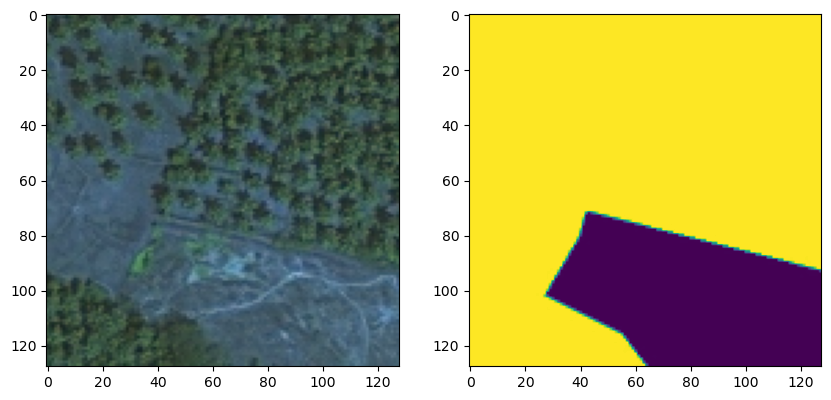

In [38]:
random_number = random.randint(0,500)

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(X[random_number])
ax[1].imshow(y[random_number])

In [39]:
## splitting the image into train and test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=23)

In [40]:
## creating a unet model using tensorflow.keras layers

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

Creating a function to implement the upward part of convolutions in the unet model


In [41]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

Combining the upward and downward part of the unet model


In [42]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [43]:
## creating and compiling a model

model = unet_model(n_filters=32,input_size=(128,128,3))

## let's use loss as binary_crossentropy since we have only two output fields: forest area and non-forest area
model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
## getting the model summary

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

Creating ModelCheckpoint and EarlyStopping callbacks for the unet model training

In [45]:
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive",save_best_only=True)

Training the model...

In [46]:
num_epochs = 10

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/10
144/144 [==============================] - 984s 7s/step - loss: 0.5755 - accuracy: 0.7005 - val_loss: 0.5291 - val_accuracy: 0.7453
Epoch 2/10
144/144 [==============================] - 938s 7s/step - loss: 0.5247 - accuracy: 0.7449 - val_loss: 0.4781 - val_accuracy: 0.7731
Epoch 3/10
144/144 [==============================] - 937s 7s/step - loss: 0.6068 - accuracy: 0.7261 - val_loss: 0.6315 - val_accuracy: 0.6970
Epoch 4/10
144/144 [==============================] - 926s 6s/step - loss: 0.5662 - accuracy: 0.7132 - val_loss: 0.5200 - val_accuracy: 0.7479
Epoch 5/10
144/144 [==============================] - 930s 6s/step - loss: 0.5291 - accuracy: 0.7395 - val_loss: 0.5020 - val_accuracy: 0.7584
Epoch 6/10
144/144 [==============================] - 941s 7s/step - loss: 0.5170 - accuracy: 0.7461 - val_loss: 0.4968 - val_accuracy: 0.7601
Epoch 7/10
144/144 [==============================] - 902s 6s/step - loss: 0.5053 - accuracy: 0.7532 - val_loss: 0.4985 - val_accuracy: 0.7579

Visualizing

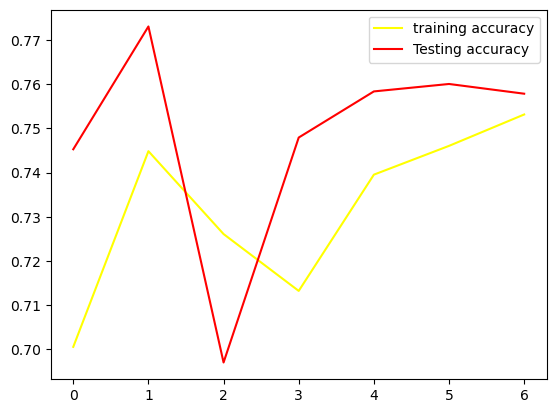

In [47]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='yellow',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

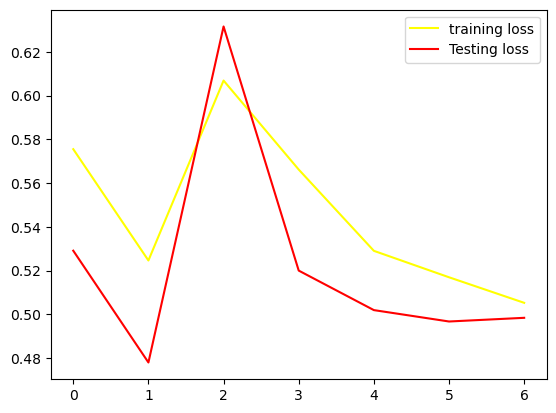

In [48]:
# creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='yellow',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

Randomly visualizing the original image, its original mask and the predicted mask

1/1 [==============================] - 1s 763ms/step


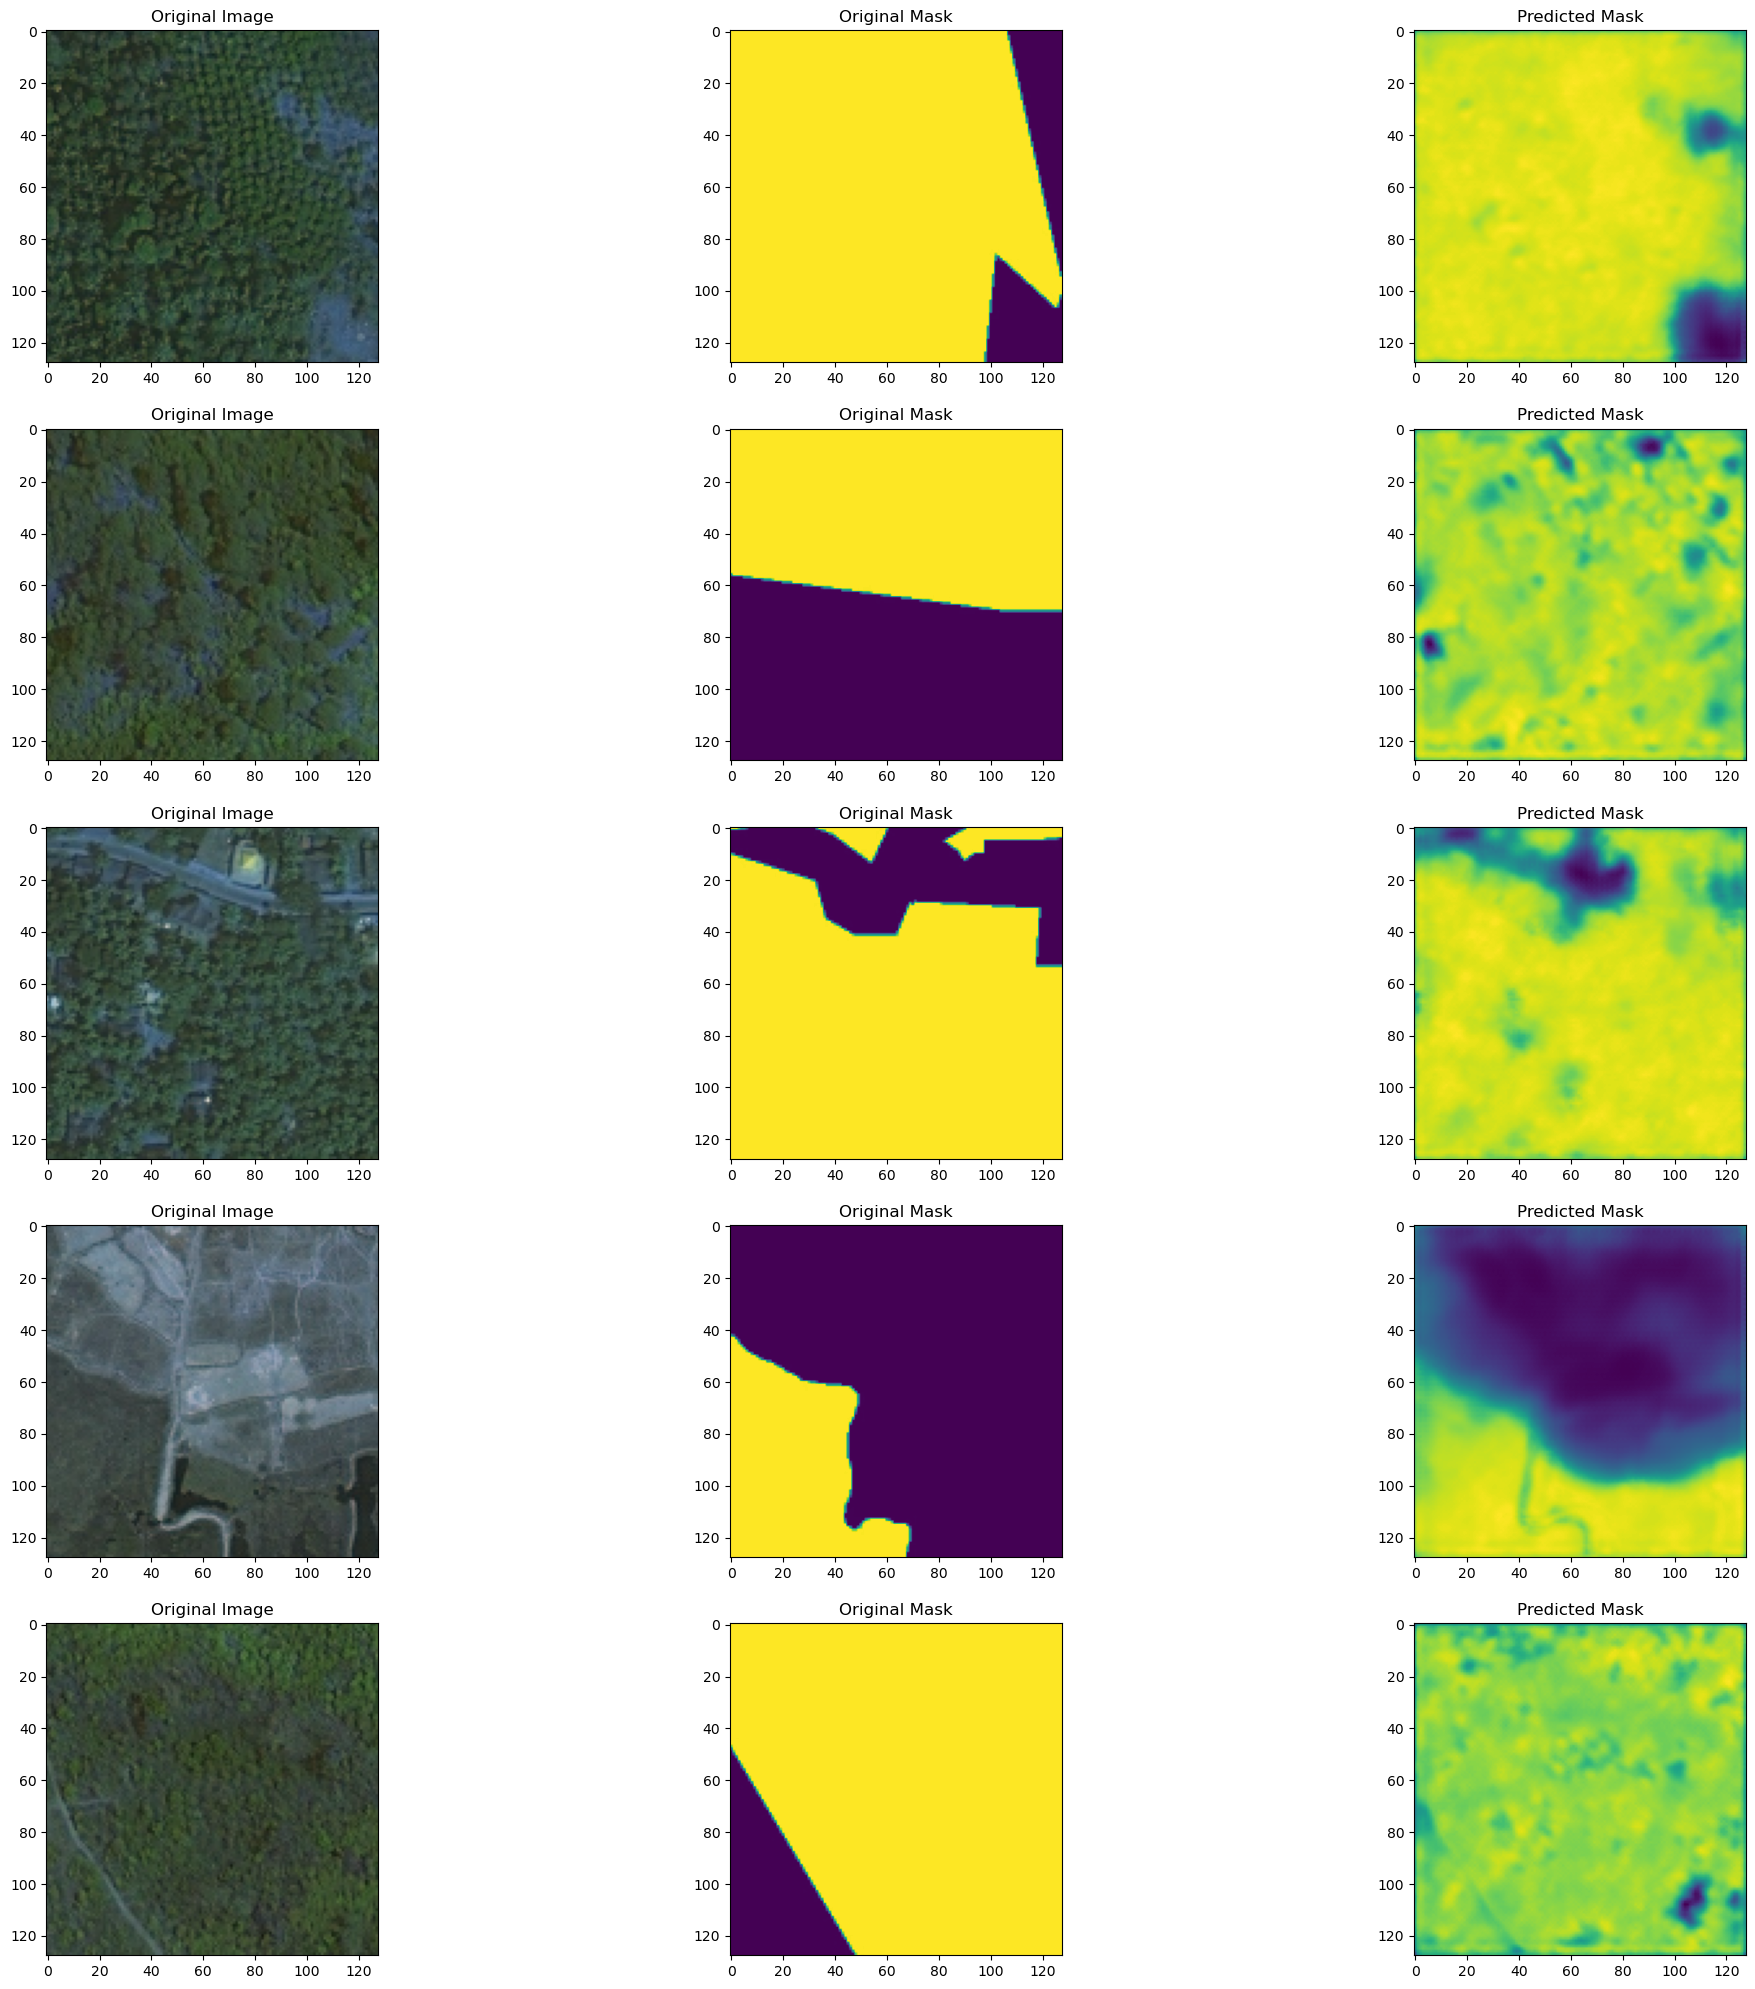

In [49]:
figure, axes = plt.subplots(5,3, figsize=(25,25))

for i in range(0,5):
    rand_num = random.randint(0,400)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')

From the result above, using U-Net Architecture the result of the training is val_loss: 0.4985 - val_accuracy: 0.7579. that means the accuracy of the model is 75.79%. this model achieve less 4% more accurate from the UNet Architecture + Soft Attention.